# LSTM baseline for JPX Tokyo Stock Exchange Prediction


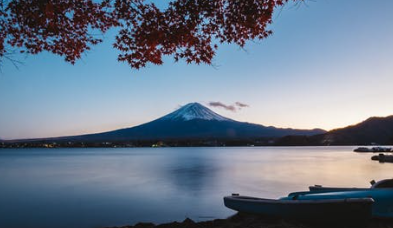


Thank you for your checking this notebook.

This is my baseline for "JPX Tokyo Stock Exchange Prediction" competition [(Link)](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/overview) with Keras - LSTM. Based on this [EDA](https://www.kaggle.com/code/hechtjp/jpx-eda-key-event-japan-market), I will try simple LSTM with closing price as input and predict target directly.  

If you think this notebook is interesting, please give your comment or question and I appreciate your upvote as well. :) 

<a id='top'></a>
## Contents
1. [Import Library & Set Config](#config)
2. [Load Data](#load)
3. [Preprocessing Data](#prep)
4. [Define & Train Model](#model)
5. [Prediction with API](#pred)
6. [Conclusion](#conclusion)
7. [Reference](#ref)

## Version History
Ver.3  Baseline.
Ver.6  Increased TIME_WINDOW to 32 but time out error occurred (overed 12hrs)
Ver.7  Epoch reduced to 10.
Ver.8  Changed TRAIN_PERIOD = ['2021.06.01', '2021.12.03']

<a id='config'></a>

---
# 1. Import Library & Set Config
---

[Back to Contents](#top)

In [ ]:
# === General ===
import sys, warnings, time, os, copy, gc, re, random, cudf
import pickle as pkl
warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
# pd.set_option("display.max_colwidth", 10000)
import seaborn as sns
sns.set()
from pandas.io.json import json_normalize
from pprint import pprint
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime, timedelta

# Pre-Processing
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold

# Model
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd

In [ ]:
# Configuration
DEBUG = False
PATH_INPUT = r'../input/jpx-tokyo-stock-exchange-prediction'
TIME_WINDOW = 32
LEARNING_RATE = 0.01

if DEBUG:
    TRAIN_PERIOD = ['2021.06.01', '2021.12.03']
    epc = 2
    batch_size=50
    
else:
    TRAIN_PERIOD = ['2021.06.01', '2021.12.03']
    epc = 10
    batch_size=50

<a id='load'></a>

---
# 2. Load Data

Based on the [Data Description](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/data), first I am loading the "stock_prices.csv" under "train_files" and use the "close" & "target" data to train LSTM model.

- ../train_files/stock_prices.csv: Price info of stock covering the main training period.


---

[Back to Contents](#top)

In [ ]:
dfPriceTrain = cudf.read_csv(PATH_INPUT + r'/train_files/stock_prices.csv', usecols=['Date', 'SecuritiesCode', 'Close', 'Target'])
dfPriceTrain['Date'] = cudf.to_datetime(dfPriceTrain['Date'])
dfPriceTrain.set_index('Date', inplace=True)
dfPriceTrain

In [ ]:
dfPriceTrain = dfPriceTrain.loc[TRAIN_PERIOD[0]:TRAIN_PERIOD[1],:]
dfPriceTrain

<a id='prep'></a>

---
# 3. Preprocessing Data

1. Logarithmic transform with log1p
2. Change scale btw. 0 - 1 by MinMaxScaler
3. Filter by each "SecuritiesCodes", create data for training from "Close" [ "batch_size" : "TIME_WINDOW" : 1 ] and data for label from "Target" ["batch_size":1:1]. If there is nan. value, let's interpolate that.

---

[Back to Contents](#top)

In [ ]:
dfPriceTrain = dfPriceTrain.to_pandas()

dfPriceTrain['Close'] = dfPriceTrain['Close'].apply(np.log1p)
dfPriceTrain

In [ ]:
mm = MinMaxScaler()
dfPriceTrain['Close'] = mm.fit_transform(dfPriceTrain['Close'].values.reshape([-1, 1]))

pkl.dump(mm, open('scaler.pkl', 'wb'))

In [ ]:
listSC = dfPriceTrain['SecuritiesCode'].unique().tolist()
X = []
Y = []

for sc in tqdm(listSC):
    dfTemp = dfPriceTrain[dfPriceTrain['SecuritiesCode'] == sc]
    dfTemp = dfTemp.interpolate()
    dfTemp = dfTemp.dropna(how='any')
    iterN = (dfTemp.shape[0] - TIME_WINDOW + 1)
    
    for i in range(iterN):
        x = dfTemp['Close'].iloc[i:(i+TIME_WINDOW)].to_numpy().reshape([TIME_WINDOW, 1])
        y = dfTemp['Target'].iat[(i+TIME_WINDOW-1)].reshape([1, 1])

        X.append(x)
        Y.append(y)

X = np.array(X)
Y = np.array(Y) 

assert X.shape[0] == Y.shape[0], "Shape of X or Y are not correct."
print(f'Shape of train data: X = {X.shape}, Y = {Y.shape}.')

In [ ]:
assert np.count_nonzero(np.isnan(X)) == 0, f'There is nan in X data. {np.argwhere(np.isnan(X))}'

<a id='model'></a>

---
# 4. Define & Train Model

- Define simple LSTM model which has one LSTM layer in both encoder and decoder.
- 80% of X is for training and rest 20% of X is for calidation.

---

[Back to Contents](#top)

In [ ]:
def define_model(dfx, dfy, n_hidden=100):
    
    input_train = Input(shape=(dfx.shape[1], dfx.shape[2]))
    output_train = Input(shape=(dfy.shape[1], dfy.shape[2]))

    encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
    return_sequences=False, return_state=True)(input_train)

    encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
    encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
    
    decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
    decoder = LSTM(n_hidden, activation='elu', dropout=0.2,
    recurrent_dropout=0.2, return_state=False,
    return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

    out = TimeDistributed(Dense(output_train.shape[2]))(decoder)

    model = Model(inputs=input_train, outputs=out)
    opt = Adam(lr=LEARNING_RATE, clipnorm=1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
    model.summary()
    
    return model

In [ ]:
def train_model(dfx, dfy, model):

    es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
    history = model.fit(dfx, dfy, validation_split=0.2, epochs=epc, verbose=1,
                        callbacks=[es], batch_size=batch_size)
    train_mae = history.history['mae']
    valid_mae = history.history['val_mae']
    
    return model, train_mae, valid_mae

In [ ]:
def plot_mae(train_mae, valid_mae):
    plt.plot(train_mae, label='train mae'),
    plt.plot(valid_mae, label='validation mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.title('train vs. validation accuracy (mae)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=
    2)
    plt.show()

In [ ]:
startTime = time.time()

trainX = X
trainY = Y

model = define_model(trainX, trainY, n_hidden=100)

model, train_mae, valid_mae = train_model(trainX, trainY, model)

model.save(f'model.h5')

plot_mae(train_mae, valid_mae)

print(f'Training time was {time.time() - startTime:.2f} [s].\n')

<a id='pred'></a>

---
# 5. Prediction with time-series API

- Following the explanation from the organizer [here](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/overview/evaluation)
- As recommended in [this web page](https://logmi.jp/tech/articles/325898), using try and except to continue the prediction during the loop by API.
- My model is using past data as input but API gives me only one day data. So I need to prepare two data frame, one is about data before date which API gives and another one is to keep data which API gives during the loop.

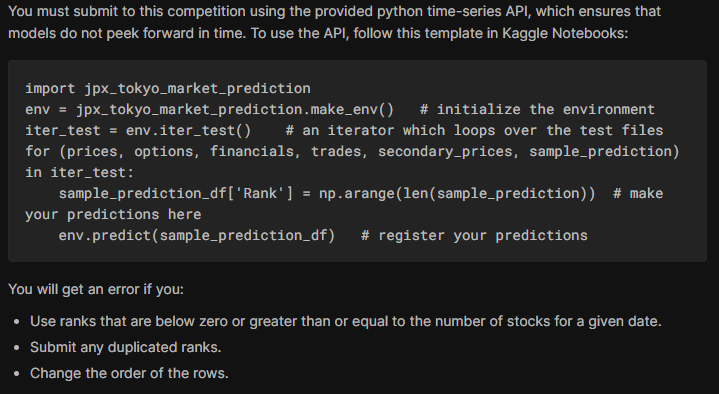


---

[Back to Contents](#top)

In [ ]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [ ]:
count = 0
countExcept = 0

# Prepare dataframe with past data for prediction.
dfPrice = pd.read_csv(PATH_INPUT + r'/train_files/stock_prices.csv', usecols=['Date', 'SecuritiesCode', 'Close'])
dfPrice['Date'] = pd.to_datetime(dfPrice['Date'])
dfPrice.set_index('Date', inplace=True)
dfPrice = dfPrice.loc[TRAIN_PERIOD[0]:TRAIN_PERIOD[1],:]
dfPrice

In [ ]:
def prepare_data(df, listSC, mm):
    '''Pre-processing and prepare data with target shape securitiesCode y securitiesCode.'''
    
    X = []
    for sc in tqdm(listSC):
        dfTemp = df[df['SecuritiesCode'] == sc]
        dfTemp['Close'] = dfTemp['Close'].apply(np.log1p)
        dfTemp['Close'] = mm.transform(dfTemp['Close'].values.reshape([-1, 1]))
        dfTemp = dfTemp.interpolate()
        dfTemp = dfTemp.fillna(0)
        x = dfTemp['Close'].to_numpy().reshape([TIME_WINDOW, 1])
        X.append(x)
        
    X = np.array(X)
    assert X.shape == (2000, TIME_WINDOW, 1), "Shape of X is not correct."
    return X

In [ ]:
def predict_rank(X, model, sample_prediction, listSC):
    '''Predict Target value and make a ranking. Return submittion df.'''
    
    Y = model.predict(X)
    dfY = pd.DataFrame(Y.reshape(-1, 1))
    dfSC = pd.DataFrame(listSC)
    dfTemp = pd.concat([dfSC, dfY], axis=1)
    dfTemp.columns = ['SecuritiesCode', 'prediction']
    dfTemp['Rank'] = dfTemp["prediction"].rank(ascending=False,method="first") -1
    dfTemp['Rank'] = dfTemp['Rank'].astype(int)
    dfTemp = dfTemp.drop('prediction', axis=1)
    sample_prediction = sample_prediction.drop('Rank', axis=1)
    dfSub = sample_prediction.merge(dfTemp, on='SecuritiesCode', how='left')

    assert dfSub.shape == (2000, 3), "Shape of dfSub is not correct."
    return dfSub    

In [ ]:
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    try:
        prices = prices[['Date', 'SecuritiesCode', 'Close']]
        prices['Date'] = pd.to_datetime(prices['Date'])
        prices.set_index('Date', inplace=True)
        
        dfPrice = pd.concat([dfPrice, prices], axis=0)
        dfTarget = dfPrice.tail(TIME_WINDOW*2000)  # Number of Target code is 2000 and each code need data "TIME_WINDOW" 
        
        X = prepare_data(dfTarget, listSC, mm)
        dfSub = predict_rank(X, model, sample_prediction, listSC)
        display(dfSub)
        env.predict(dfSub)
        count += 1
              
    except:
        env.predict(sample_prediction)
        count += 1
        countExcept += 1

In [ ]:
print(f'Finished prediction. {countExcept} / {count} times exception occurred. \n')

<a id='conclusion'></a>

---
# 6. Conclusion
- Debugging in API was very difficult because there was no detail info about the occurred exception :(
- Ver.3 the mae was not improved already after 2nd epoch.  

---

[Back to Contents](#top)

<a id='ref'></a>

---
# 7. Reference
1. [JPX_EDA_with_cudf_&_Key_Events_Japan_Market](https://www.kaggle.com/code/hechtjp/jpx-eda-with-cudf-key-events-japan-market?scriptVersionId=94993105)
2. [Building Seq2Seq LSTM with Luong Attention in Keras for Time Series Forecasting](https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb)
3. [ポイントを押さえればTime-seriesコンペは怖くない
堅牢で速いコードを書くためのテクニックと心構え](https://logmi.jp/tech/articles/325898)

---

[Back to Contents](#top)